# Model Comparison Analysis: Sonnet 4.5 vs GPT 4.1

Comparing game outcomes, negotiation patterns, and player scores across two model types.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Consistent color palette for contract types
CONTRACT_COLORS = {
    'strict': 'red',
    'none': 'blue',
    'contract_for_finishing': 'green',
    'tile_with_judge_implementation': 'goldenrod'  # Darker yellow for visibility
}

# Order for contract types (none on left, strict on right)
CONTRACT_ORDER = ['none', 'contract_for_finishing', 'tile_with_judge_implementation', 'strict']


In [ ]:
# Load data from results/final/
four1 = pd.read_csv('results/final/FOUR_1-FOUR_1.csv')
sonnet = pd.read_csv('results/final/SONNET_4_5-SONNET_4_5.csv')
haiku = pd.read_csv('results/final/HAIKU_4_5-HAIKU_4_5.csv')

# Add model label
four1['Model'] = 'GPT 4.1'
sonnet['Model'] = 'Sonnet 4.5'
haiku['Model'] = 'Haiku 4.5'

# Combine all models
df = pd.concat([four1, sonnet, haiku], ignore_index=True)

# Filter to Regular Trading only (no Pay4Partner)
df = df[df['Pay4Partner'] == False].copy()

# Clean contract type
df['Contract Type'] = df['Contract Type'].fillna('none')

print(f"GPT 4.1 rows (after P4P filter): {len(df[df['Model']=='GPT 4.1'])}")
print(f"Sonnet 4.5 rows (after P4P filter): {len(df[df['Model']=='Sonnet 4.5'])}")
print(f"Haiku 4.5 rows (after P4P filter): {len(df[df['Model']=='Haiku 4.5'])}")
print(f"Total: {len(df)}")
print(f"\nContract Types: {df['Contract Type'].unique()}")
print(f"Buckets: {df['Bucket'].unique()}")


GPT 4.1 rows (after P4P filter): 576
Sonnet 4.5 rows (after P4P filter): 576
Total: 1152

Contract Types: ['none' 'tile_with_judge_implementation' 'strict' 'contract_for_finishing']
Buckets: ['Needy Player Blue' 'Mutual Dependency'
 'Independent Both have optimal paths']


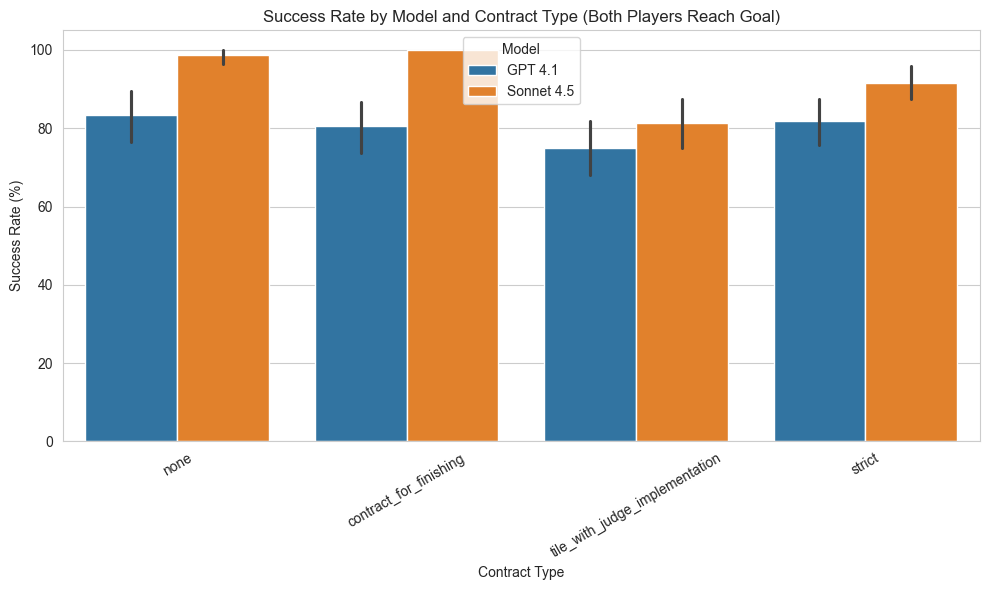

In [3]:
# Create success flag
df['Success'] = (df['Reached Goal Player 0'] == True) & (df['Reached Goal Player 1'] == True)

# Plot success rate by model and contract type
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df,
    x='Contract Type',
    y='Success',
    hue='Model',
    order=CONTRACT_ORDER,
    estimator=lambda x: sum(x) / len(x) * 100,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Contract Type')
ax.set_title('Success Rate by Model and Contract Type (Both Players Reach Goal)')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


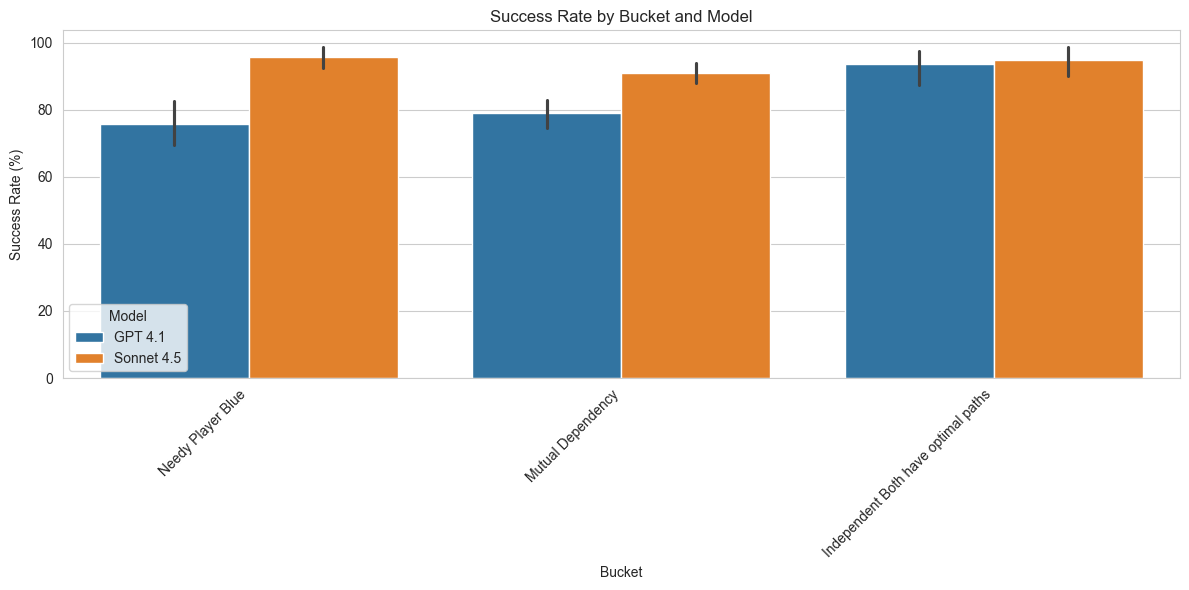

In [4]:
# Success Rate by Bucket (comparing models)
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=df,
    x='Bucket',
    y='Success',
    hue='Model',
    estimator=lambda x: sum(x) / len(x) * 100,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Bucket')
ax.set_title('Success Rate by Bucket and Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


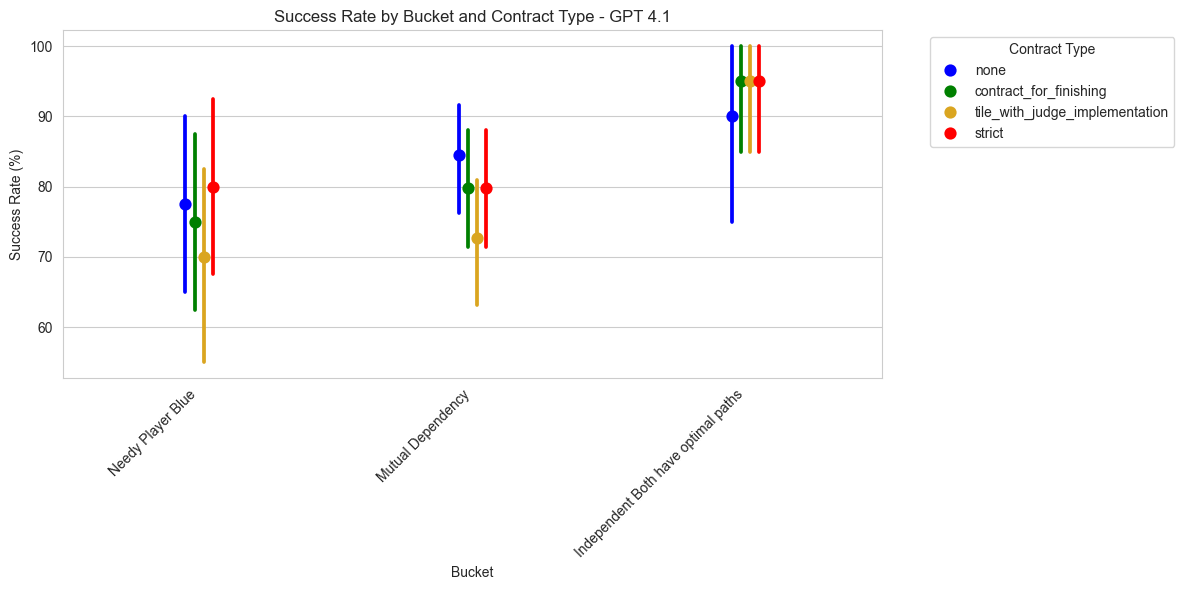

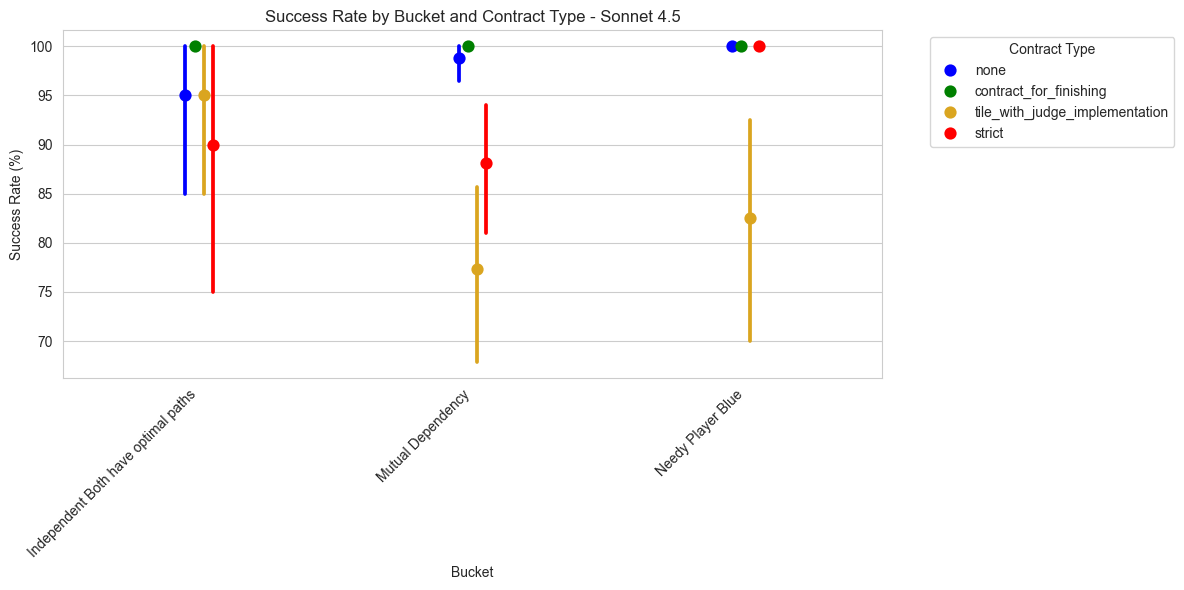

In [5]:
# Success Rate by Bucket and Contract Type (per model)
for model in df['Model'].unique():
    model_data = df[df['Model'] == model]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.pointplot(
        data=model_data,
        x='Bucket',
        y='Success',
        hue='Contract Type',
        hue_order=CONTRACT_ORDER,
        palette=CONTRACT_COLORS,
        estimator=lambda x: sum(x) / len(x) * 100,
        errorbar='ci',
        dodge=True,
        markers='o',
        linestyles='',
        ax=ax
    )
    
    ax.set_ylabel('Success Rate (%)')
    ax.set_xlabel('Bucket')
    ax.set_title(f'Success Rate by Bucket and Contract Type - {model}')
    plt.xticks(rotation=45, ha='right')
    ax.legend(title='Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


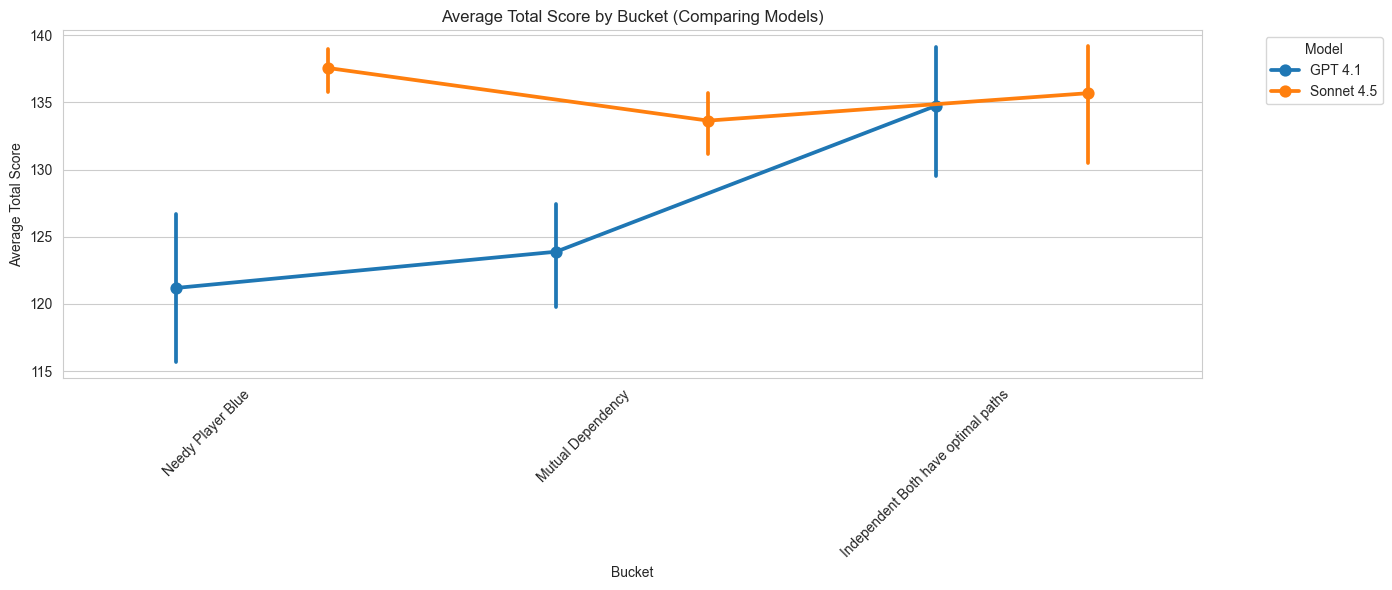

In [6]:
# Average Total Score by Bucket and Contract Type (comparing models)
fig, ax = plt.subplots(figsize=(14, 6))

sns.pointplot(
    data=df,
    x='Bucket',
    y='Total Score',
    hue='Model',
    errorbar='ci',
    dodge=0.4,
    ax=ax
)

ax.set_ylabel('Average Total Score')
ax.set_xlabel('Bucket')
ax.set_title('Average Total Score by Bucket (Comparing Models)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


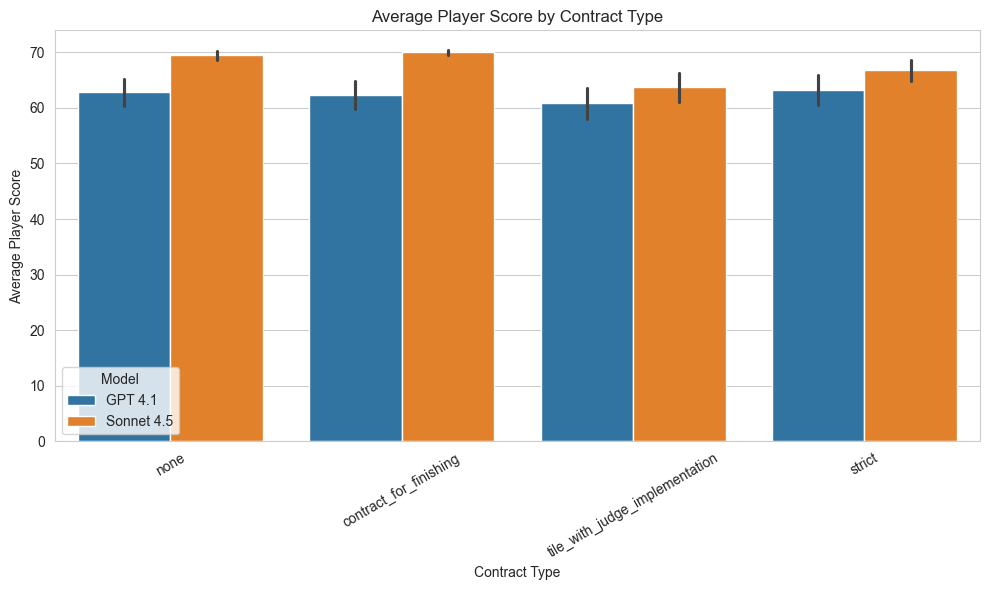

In [7]:
# Average Player Score by Contract Type (comparing models)
fig, ax = plt.subplots(figsize=(10, 6))

# Reshape for both players
scores_by_contract = df.melt(
    id_vars=['Model', 'Contract Type'],
    value_vars=['Score Player 0', 'Score Player 1'],
    var_name='Player',
    value_name='Score'
)
scores_by_contract['Player'] = scores_by_contract['Player'].str.replace('Score ', '')

sns.barplot(
    data=scores_by_contract,
    x='Contract Type',
    y='Score',
    hue='Model',
    order=CONTRACT_ORDER,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Average Player Score')
ax.set_xlabel('Contract Type')
ax.set_title('Average Player Score by Contract Type')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


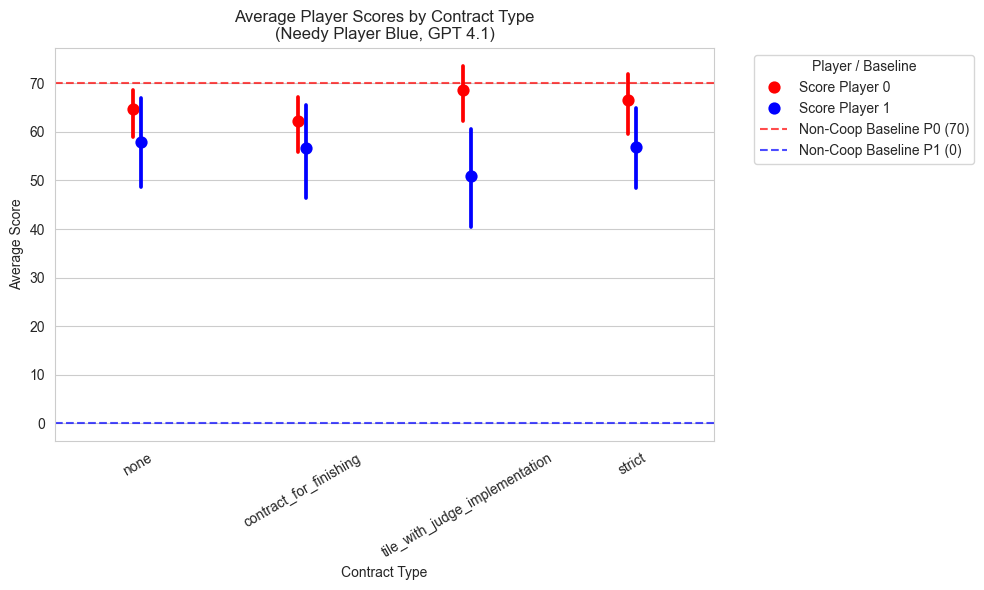

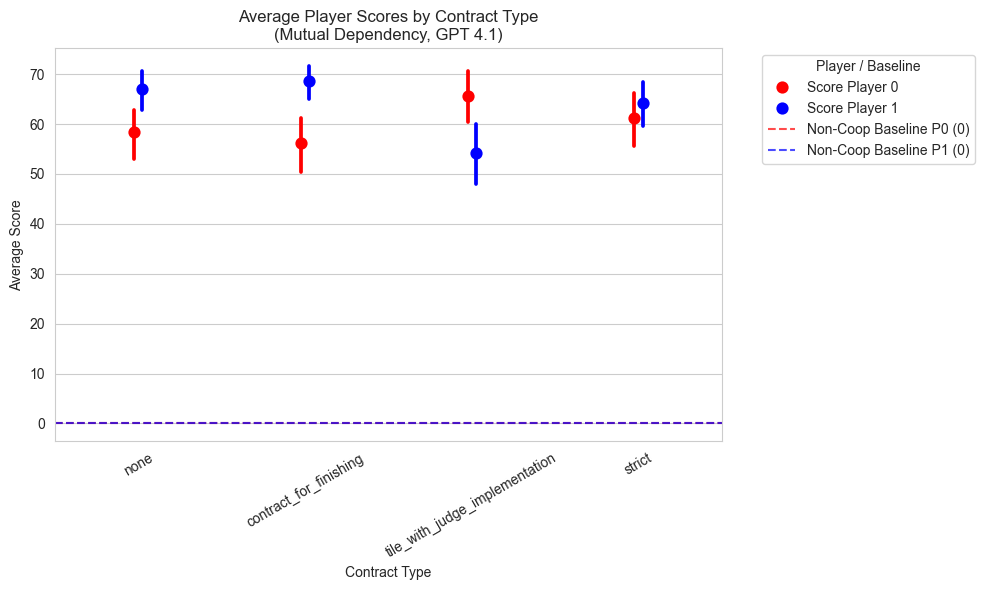

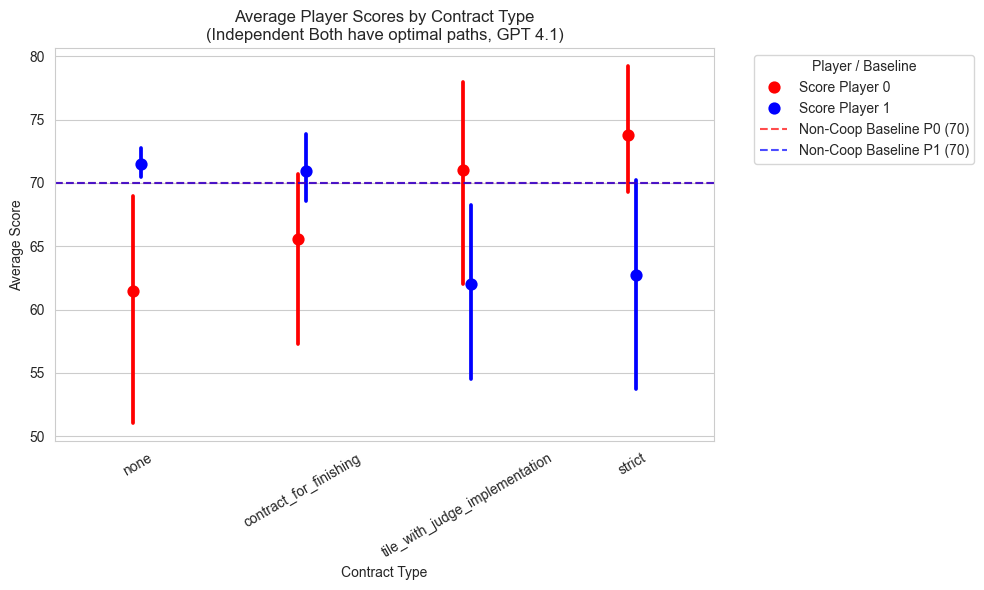

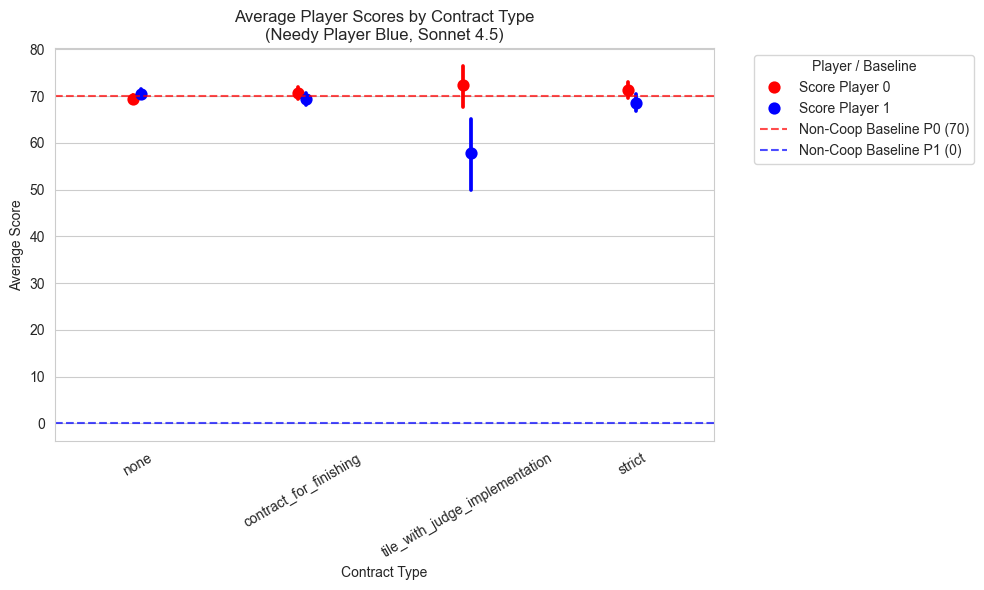

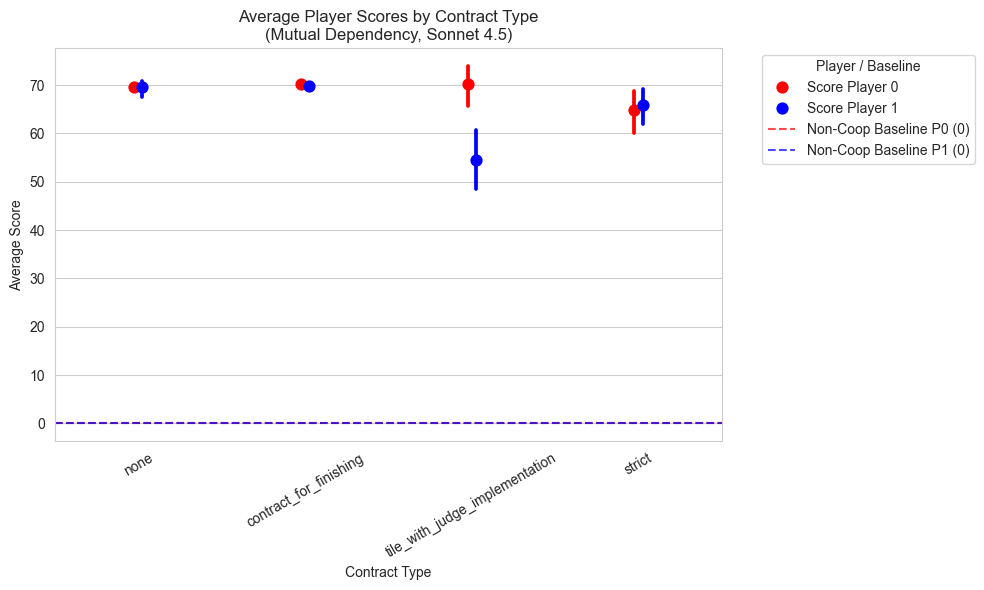

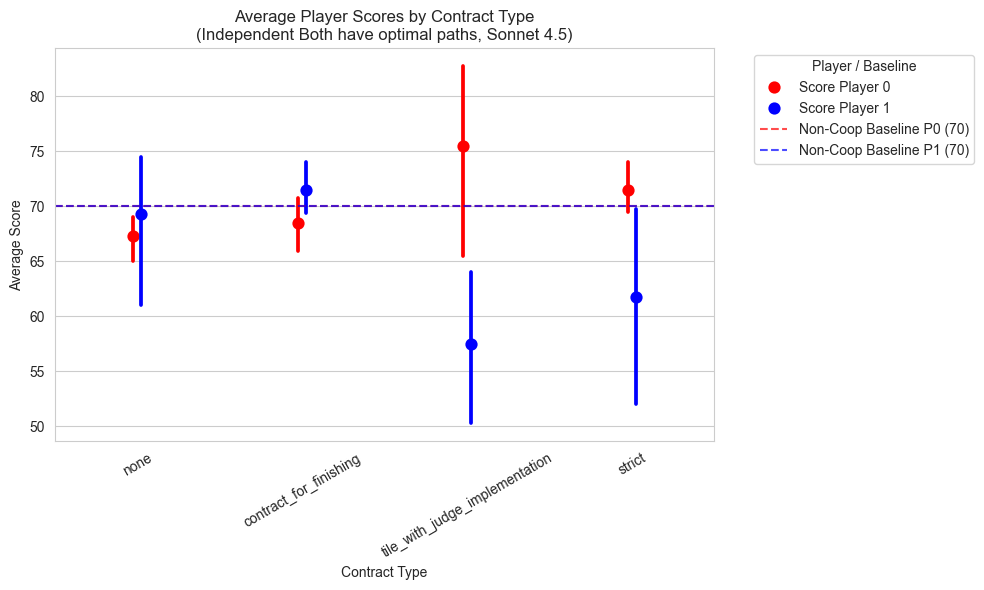

In [8]:
# Average Player Scores by Contract Type (per bucket, per model) - with baselines
for model in df['Model'].unique():
    for bucket in df['Bucket'].unique():
        subset = df[(df['Model'] == model) & (df['Bucket'] == bucket)].copy()
        
        if len(subset) == 0:
            continue
        
        # Reshape to long format
        df_long = subset.melt(
            id_vars=['Contract Type'],
            value_vars=['Score Player 0', 'Score Player 1'],
            var_name='Player',
            value_name='Score'
        )
        
        # Compute baseline scores (if available in data)
        baseline_p0 = 0
        baseline_p1 = 0
        if 'Non-Cooperative Baseline Player 0' in subset.columns:
            baseline_p0 = subset['Non-Cooperative Baseline Player 0'].mean()
        if 'Non-Cooperative Baseline Player 1' in subset.columns:
            baseline_p1 = subset['Non-Cooperative Baseline Player 1'].mean()
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        sns.pointplot(
            data=df_long,
            x='Contract Type',
            y='Score',
            hue='Player',
            order=CONTRACT_ORDER,
            errorbar='ci',
            dodge=True,
            markers='o',
            linestyles='',
            palette={'Score Player 0': 'red', 'Score Player 1': 'blue'},
            ax=ax
        )
        
        # Add baseline lines
        ax.axhline(y=baseline_p0, color='red', linestyle='--', alpha=0.7, 
                   label=f'Non-Coop Baseline P0 ({baseline_p0:.0f})')
        ax.axhline(y=baseline_p1, color='blue', linestyle='--', alpha=0.7,
                   label=f'Non-Coop Baseline P1 ({baseline_p1:.0f})')
        
        ax.set_ylabel('Average Score')
        ax.set_xlabel('Contract Type')
        ax.set_title(f'Average Player Scores by Contract Type\n({bucket}, {model})')
        plt.xticks(rotation=30)
        
        # Combine legends
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Player / Baseline', 
                  bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()


In [9]:
# Zero Score Analysis - How often players fail completely
df['Player 0 Zero'] = df['Score Player 0'] == 0
df['Player 1 Zero'] = df['Score Player 1'] == 0
df['Both Zero'] = df['Player 0 Zero'] & df['Player 1 Zero']

# Zero score rates by model and contract type
zero_stats = df.groupby(['Model', 'Contract Type']).agg({
    'Player 0 Zero': 'mean',
    'Player 1 Zero': 'mean', 
    'Both Zero': 'mean'
}).round(3) * 100

print("=== Zero Score Rates (%) by Model and Contract Type ===\n")
display(zero_stats)


=== Zero Score Rates (%) by Model and Contract Type ===



Player 0 Zero  Player 1 Zero  \
Model      Contract Type                                                  
GPT 4.1    contract_for_finishing                    5.6            4.2   
           none                                     11.1            9.7   
           strict                                    9.7           11.1   
           tile_with_judge_implementation            8.3           20.8   
Sonnet 4.5 contract_for_finishing                    0.0            0.0   
           none                                      0.0            1.4   
           strict                                    4.9            4.9   
           tile_with_judge_implementation            4.9           16.0   

                                           Both Zero  
Model      Contract Type                              
GPT 4.1    contract_for_finishing                2.8  
           none                                  4.2  
           strict                                2.8  
           tile_with_judge_implementation        4.2  
Sonnet 4.5 contract_for_finishing                0.0  
           none                                  0.0  
           strict                                1.4  
           tile_with_judge_implementation        2.1

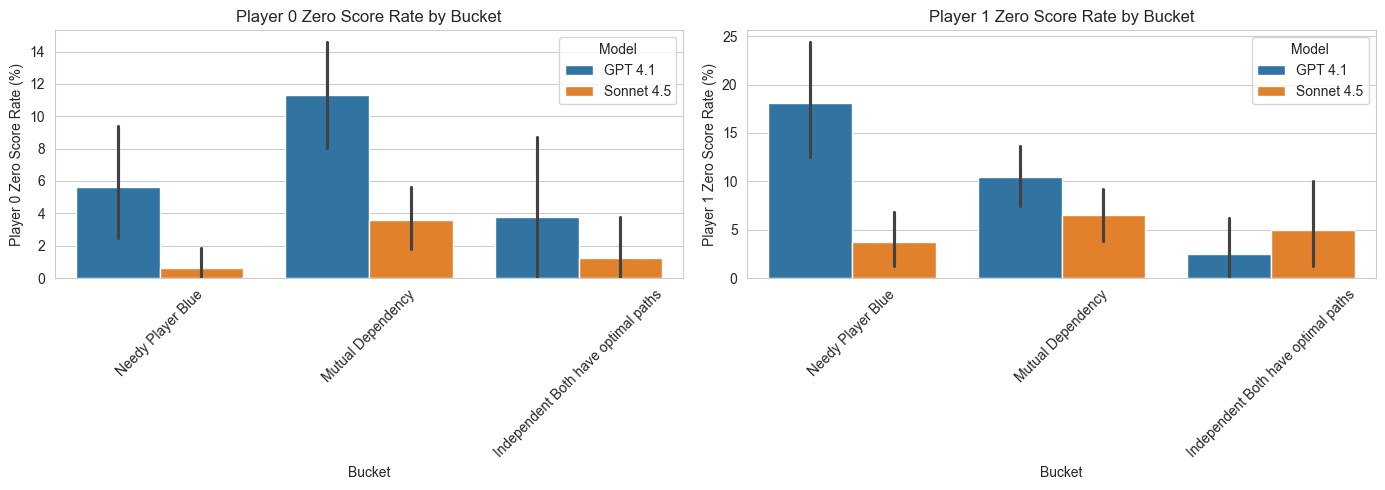

In [10]:
# Zero Score by Bucket and Model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Player 0 zero scores
sns.barplot(
    data=df,
    x='Bucket',
    y='Player 0 Zero',
    hue='Model',
    estimator=lambda x: sum(x) / len(x) * 100,
    errorbar='ci',
    ax=axes[0]
)
axes[0].set_ylabel('Player 0 Zero Score Rate (%)')
axes[0].set_xlabel('Bucket')
axes[0].set_title('Player 0 Zero Score Rate by Bucket')
axes[0].tick_params(axis='x', rotation=45)

# Player 1 zero scores
sns.barplot(
    data=df,
    x='Bucket',
    y='Player 1 Zero',
    hue='Model',
    estimator=lambda x: sum(x) / len(x) * 100,
    errorbar='ci',
    ax=axes[1]
)
axes[1].set_ylabel('Player 1 Zero Score Rate (%)')
axes[1].set_xlabel('Bucket')
axes[1].set_title('Player 1 Zero Score Rate by Bucket')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


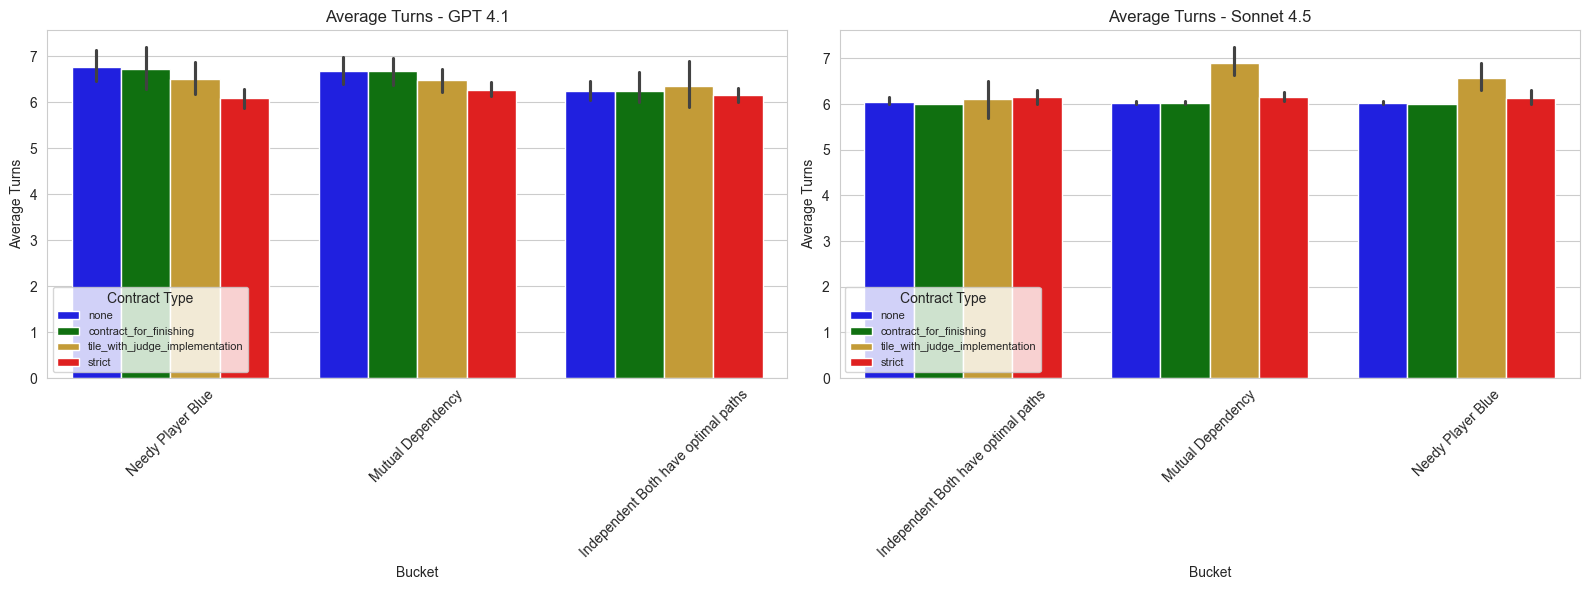

In [ ]:
# Detailed breakdown: Average Turns by Bucket and Contract Type (per model)
n_models = df['Model'].nunique()
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
if n_models == 1:
    axes = [axes]

for idx, model in enumerate(df['Model'].unique()):
    model_data = df[df['Model'] == model]
    
    sns.barplot(
        data=model_data,
        x='Bucket',
        y='Total Turns',
        hue='Contract Type',
        hue_order=CONTRACT_ORDER,
        palette=CONTRACT_COLORS,
        errorbar='ci',
        ax=axes[idx]
    )
    
    axes[idx].set_ylabel('Average Turns')
    axes[idx].set_xlabel('Bucket')
    axes[idx].set_title(f'Average Turns - {model}')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend(title='Contract Type', fontsize=8)

plt.tight_layout()
plt.show()


In [12]:
# Comprehensive Summary: By Bucket, Contract Type, and Model
print("=== Comprehensive Summary ===\n")
comprehensive = df.groupby(['Model', 'Bucket', 'Contract Type']).agg({
    'Success': ['mean', 'count'],
    'Total Turns': 'mean',
    'Total Score': 'mean',
    'Format Errors': 'mean',
}).round(2)

comprehensive.columns = ['Success_Rate', 'N_Games', 'Avg_Turns', 'Avg_Score', 'Avg_Errors']
comprehensive['Success_Rate'] = (comprehensive['Success_Rate'] * 100).round(1)

display(comprehensive)


=== Comprehensive Summary ===



Success_Rate  \
Model      Bucket                              Contract Type                                  
GPT 4.1    Independent Both have optimal paths contract_for_finishing                  95.0   
                                               none                                    90.0   
                                               strict                                  95.0   
                                               tile_with_judge_implementation          95.0   
           Mutual Dependency                   contract_for_finishing                  80.0   
                                               none                                    85.0   
                                               strict                                  80.0   
                                               tile_with_judge_implementation          73.0   
           Needy Player Blue                   contract_for_finishing                  75.0   
                                               none                                    78.0   
                                               strict                                  80.0   
                                               tile_with_judge_implementation          70.0   
Sonnet 4.5 Independent Both have optimal paths contract_for_finishing                 100.0   
                                               none                                    95.0   
                                               strict                                  90.0   
                                               tile_with_judge_implementation          95.0   
           Mutual Dependency                   contract_for_finishing                 100.0   
                                               none                                    99.0   
                                               strict                                  88.0   
                                               tile_with_judge_implementation          77.0   
           Needy Player Blue                   contract_for_finishing                 100.0   
                                               none                                   100.0   
                                               strict                                 100.0   
                                               tile_with_judge_implementation          82.0   

                                                                               N_Games  \
Model      Bucket                              Contract Type                             
GPT 4.1    Independent Both have optimal paths contract_for_finishing               20   
                                               none                                 20   
                                               strict                               20   
                                               tile_with_judge_implementation       20   
           Mutual Dependency                   contract_for_finishing               84   
                                               none                                 84   
                                               strict                               84   
                                               tile_with_judge_implementation       84   
           Needy Player Blue                   contract_for_finishing               40   
                                               none                                 40   
                                               strict                               40   
                                               tile_with_judge_implementation       40   
Sonnet 4.5 Independent Both have optimal paths contract_for_finishing               20   
                                               none                                 20   
                                               strict                               20   
                                               tile_with_judge_implementation 

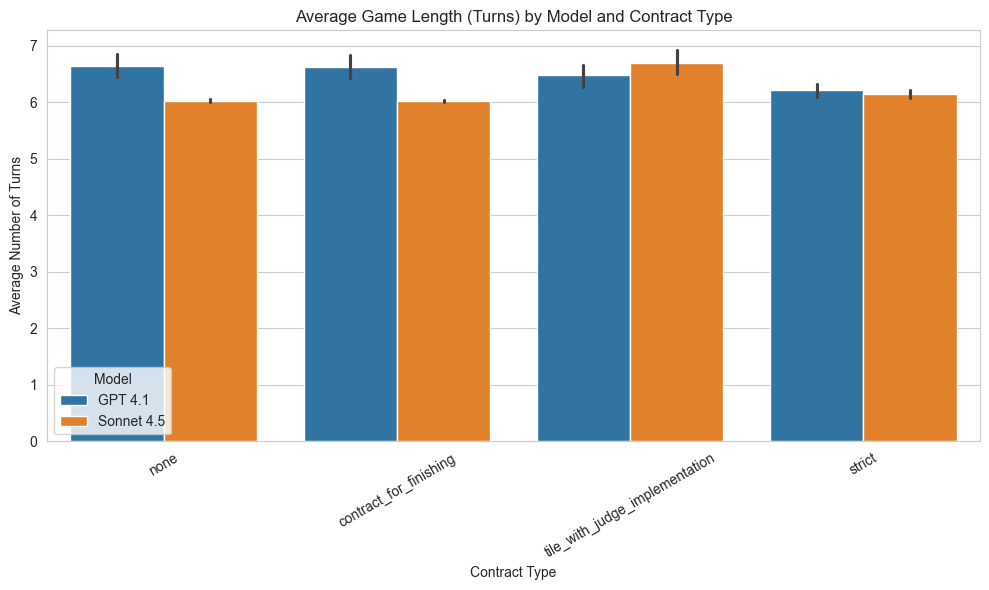

In [13]:
# Average Number of Turns by Model and Contract Type
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df,
    x='Contract Type',
    y='Total Turns',
    hue='Model',
    order=CONTRACT_ORDER,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Average Number of Turns')
ax.set_xlabel('Contract Type')
ax.set_title('Average Game Length (Turns) by Model and Contract Type')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


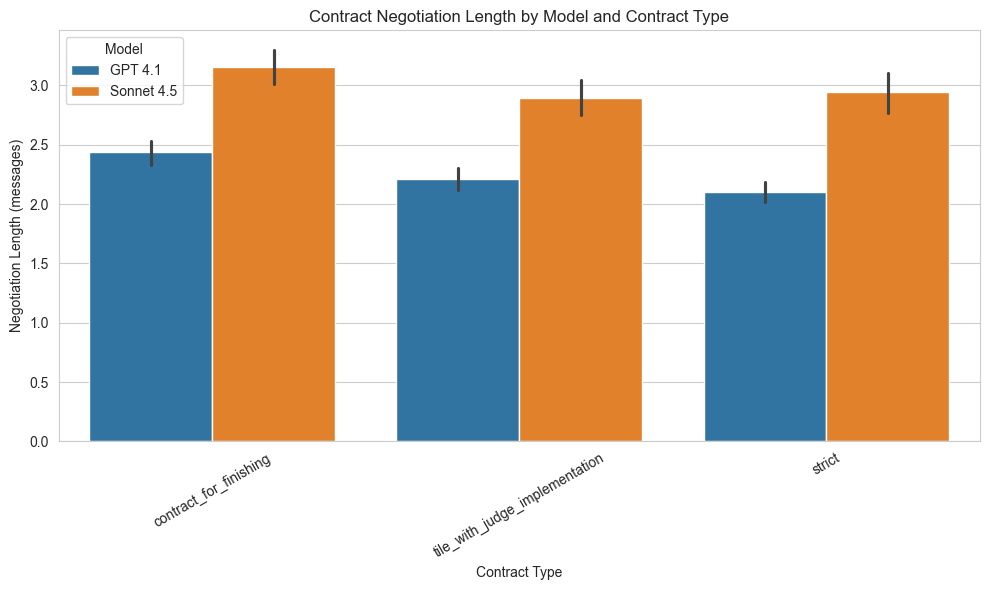

In [ ]:
# Contract Negotiation Length by Model and Contract Type
contract_games = df[df['Contract Type'] != 'none'].copy()

fig, ax = plt.subplots(figsize=(10, 6))

# Order for contract types (excluding 'none' since it's not applicable)
contract_order = [c for c in CONTRACT_ORDER if c != 'none']
contract_palette = {k: v for k, v in CONTRACT_COLORS.items() if k != 'none'}

sns.barplot(
    data=contract_games,
    x='Contract Type',
    y='contract_negotiaion_length',  # Note: typo in original column name
    hue='Model',
    order=contract_order,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Negotiation Length (messages)')
ax.set_xlabel('Contract Type')
ax.set_title('Contract Negotiation Length by Model and Contract Type')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


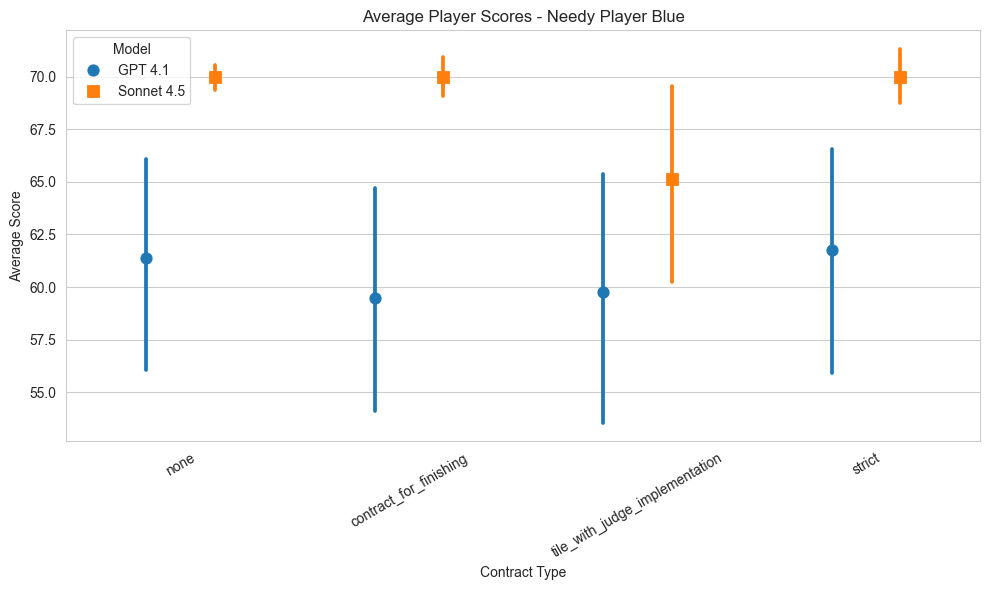

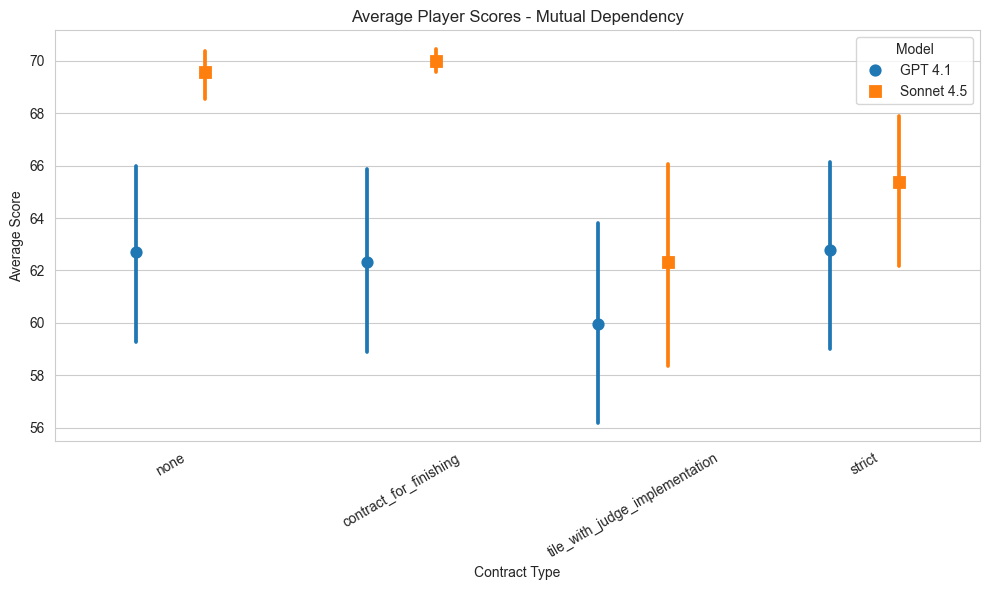

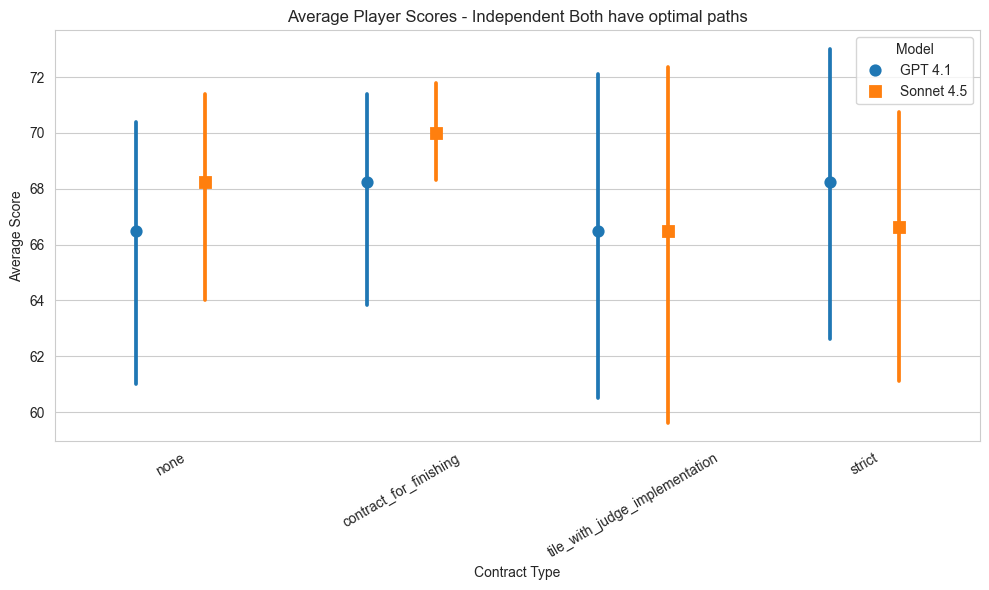

In [15]:
# Average Player Scores by Contract Type and Bucket
for bucket in df['Bucket'].unique():
    bucket_data = df[df['Bucket'] == bucket]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape for both players
    scores_long = bucket_data.melt(
        id_vars=['Model', 'Contract Type'],
        value_vars=['Score Player 0', 'Score Player 1'],
        var_name='Player',
        value_name='Score'
    )
    
    sns.pointplot(
        data=scores_long,
        x='Contract Type',
        y='Score',
        hue='Model',
        order=CONTRACT_ORDER,
        errorbar='ci',
        dodge=0.3,
        markers=['o', 's'],
        linestyles='',
        ax=ax
    )
    
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Contract Type')
    ax.set_title(f'Average Player Scores - {bucket}')
    plt.xticks(rotation=30)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


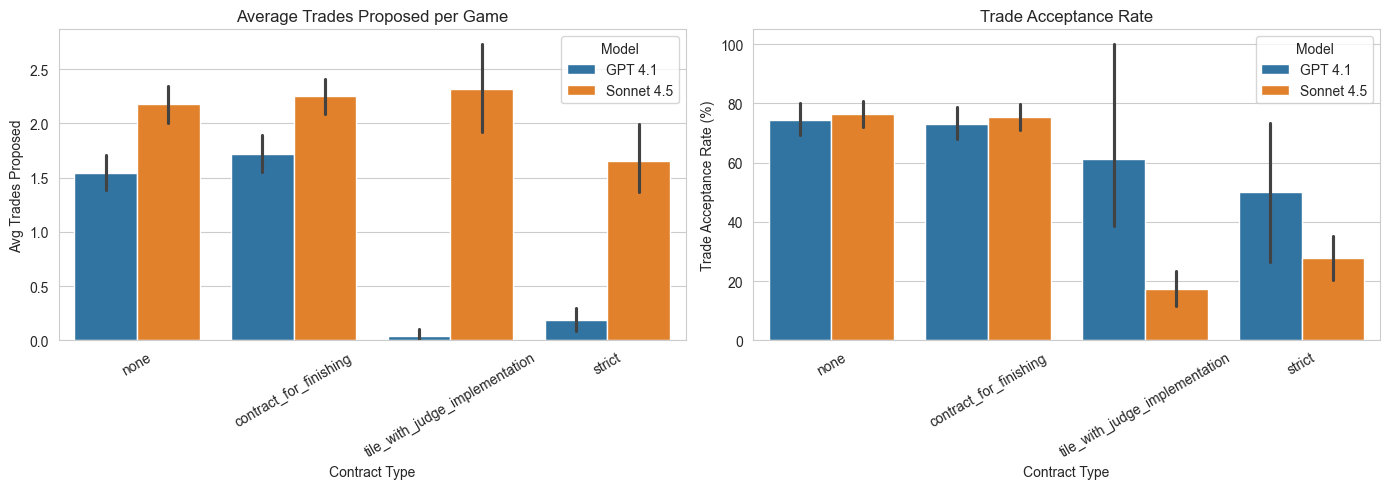

In [16]:
# Trade Activity: Proposals and Acceptances
df['Trade Acceptance Rate'] = df.apply(
    lambda x: x['Total Trades Accepted'] / x['Total Trades Proposed'] * 100 
    if x['Total Trades Proposed'] > 0 else np.nan,
    axis=1
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average trades proposed
sns.barplot(
    data=df,
    x='Contract Type',
    y='Total Trades Proposed',
    hue='Model',
    order=CONTRACT_ORDER,
    errorbar='ci',
    ax=axes[0]
)
axes[0].set_ylabel('Avg Trades Proposed')
axes[0].set_xlabel('Contract Type')
axes[0].set_title('Average Trades Proposed per Game')
axes[0].tick_params(axis='x', rotation=30)

# Plot 2: Trade acceptance rate
sns.barplot(
    data=df.dropna(subset=['Trade Acceptance Rate']),
    x='Contract Type',
    y='Trade Acceptance Rate',
    hue='Model',
    order=CONTRACT_ORDER,
    errorbar='ci',
    ax=axes[1]
)
axes[1].set_ylabel('Trade Acceptance Rate (%)')
axes[1].set_xlabel('Contract Type')
axes[1].set_title('Trade Acceptance Rate')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


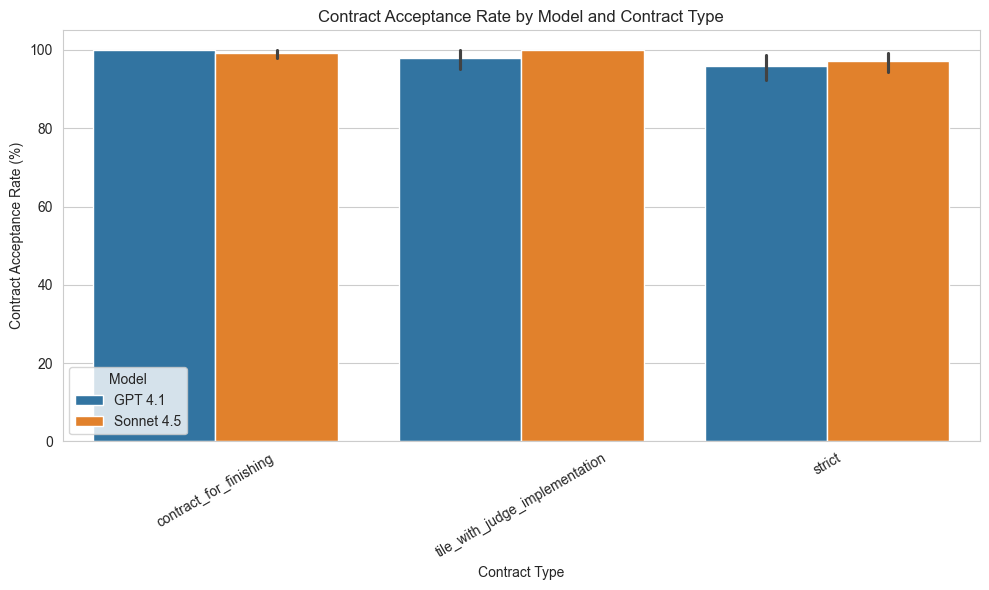

In [17]:
# Contract Acceptance Rate by Model
contract_games = df[df['Contract Type'] != 'none'].copy()

fig, ax = plt.subplots(figsize=(10, 6))

# Order for contract types (excluding 'none')
contract_order_no_none = [c for c in CONTRACT_ORDER if c != 'none']

sns.barplot(
    data=contract_games,
    x='Contract Type',
    y='contract_accepted',
    hue='Model',
    order=contract_order_no_none,
    estimator=lambda x: sum(x) / len(x) * 100,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Contract Acceptance Rate (%)')
ax.set_xlabel('Contract Type')
ax.set_title('Contract Acceptance Rate by Model and Contract Type')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


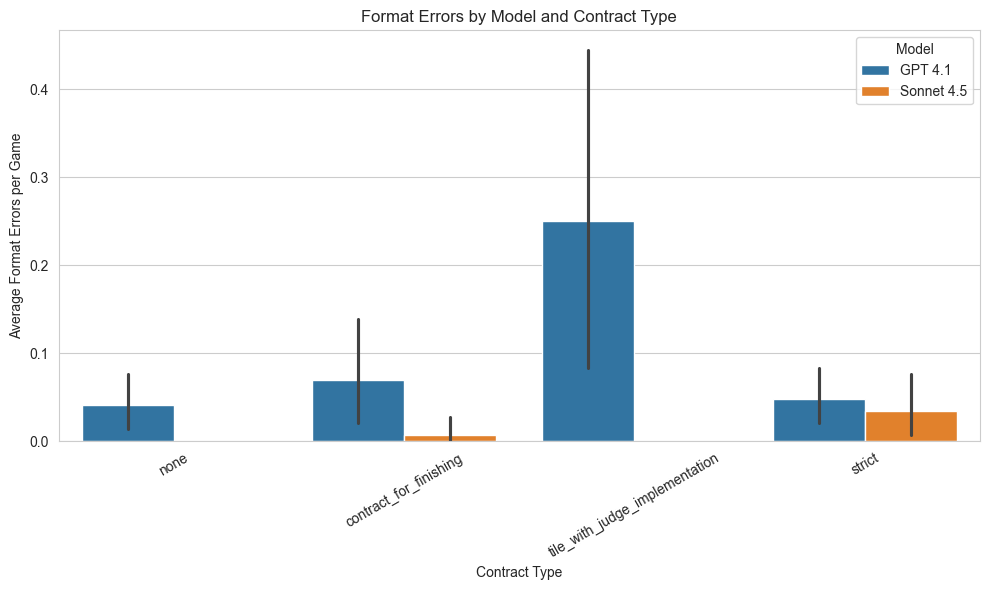

In [18]:
# Format Errors by Model and Contract Type
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df,
    x='Contract Type',
    y='Format Errors',
    hue='Model',
    order=CONTRACT_ORDER,
    errorbar='ci',
    ax=ax
)

ax.set_ylabel('Average Format Errors per Game')
ax.set_xlabel('Contract Type')
ax.set_title('Format Errors by Model and Contract Type')
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [19]:
# Summary Statistics by Model
print("=== Summary by Model ===\n")
summary = df.groupby('Model').agg({
    'Success': ['mean', 'std', 'count'],
    'Total Turns': ['mean', 'std'],
    'Total Score': ['mean', 'std'],
    'Format Errors': ['mean', 'sum'],
    'Total Trades Proposed': ['mean', 'sum'],
    'Total Trades Accepted': ['mean', 'sum'],
}).round(3)

summary.columns = ['_'.join(col) for col in summary.columns]
display(summary)


=== Summary by Model ===



,Success_mean,Success_std,Success_count,Total Turns_mean,Total Turns_std,Total Score_mean,Total Score_std,Format Errors_mean,Format Errors_sum,Total Trades Proposed_mean,Total Trades Proposed_sum,Total Trades Accepted_mean,Total Trades Accepted_sum
Model,,,,,,,,,,,,,
GPT 4.1,0.802,0.399,576,6.488,1.137,124.644,33.529,0.102,59,0.872,502,0.510,294
Sonnet 4.5,0.929,0.257,576,6.222,0.731,135.017,19.373,0.010,6,2.097,1208,0.913,526


In [ ]:
# Summary by Model and Contract Type
print("=== Summary by Model and Contract Type ===\n")
summary_by_contract = df.groupby(['Model', 'Contract Type']).agg({
    'Success': 'mean',
    'Total Turns': 'mean',
    'Total Score': 'mean',
    'Format Errors': 'mean',
    'contract_negotiaion_length': 'mean',  # Note: typo in original column name
    'Total Trades Proposed': 'mean',
    'Total Trades Accepted': 'mean',
}).round(2)

display(summary_by_contract)


=== Summary by Model and Contract Type ===



Success  Total Turns  Total Score  \
Model      Contract Type                                                       
GPT 4.1    contract_for_finishing             0.81         6.62       124.72   
           none                               0.83         6.65       125.73   
           strict                             0.82         6.21       126.53   
           tile_with_judge_implementation     0.75         6.47       121.60   
Sonnet 4.5 contract_for_finishing             1.00         6.01       140.00   
           none                               0.99         6.03       139.03   
           strict                             0.92         6.15       133.68   
           tile_with_judge_implementation     0.81         6.70       127.36   

                                           Format Errors  \
Model      Contract Type                                   
GPT 4.1    contract_for_finishing                   0.07   
           none                                     0.04   
           strict                                   0.05   
           tile_with_judge_implementation           0.25   
Sonnet 4.5 contract_for_finishing                   0.01   
           none                                     0.00   
           strict                                   0.03   
           tile_with_judge_implementation           0.00   

                                           contract_negotiation_length  \
Model      Contract Type                                                 
GPT 4.1    contract_for_finishing                                 2.44   
           none                                                   0.00   
           strict                                                 2.10   
           tile_with_judge_implementation                         2.22   
Sonnet 4.5 contract_for_finishing                                 3.15   
           none                                                   0.00   
           strict                                                 2.94   
           tile_with_judge_implementation                         2.90   

                                           Total Trades Proposed  \
Model      Contract Type                                           
GPT 4.1    contract_for_finishing                           1.72   
           none                                             1.54   
           strict                                           0.19   
           tile_with_judge_implementation                   0.04   
Sonnet 4.5 contract_for_finishing                           2.25   
           none                                             2.17   
           strict                                           1.65   
           tile_with_judge_implementation                   2.31   

                                           Total Trades Accepted  
Model      Contract Type                                          
GPT 4.1    contract_for_finishing                           1.03  
           none                                             0.92  
           strict                                           0.07  
           tile_with_judge_implementation                   0.02  
Sonnet 4.5 contract_for_finishing                           1.53  
           none                                             1.49  
           strict                                           0.37  
           tile_with_judge_implementation                   0.27